In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import time
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, RidgeCV, MultiTaskLassoCV
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,root_mean_squared_error
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor

from utils import clean_data
from utils import split_trajectories
from utils import replicate_initial_position_by_block
from utils import get_n_trajectories
from utils import plot_y_yhat

In [36]:
train = pd.read_csv('../data/X_train.csv')
test =  pd.read_csv('../data/X_test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')#This is a file with random numbers as predictions

In [37]:
train_cleaned=clean_data(train)

In [38]:
train_after_split, validation_after_split, test_after_split = split_trajectories(train_cleaned)

In [39]:
train_entry=replicate_initial_position_by_block(train_after_split)
validation_entry=replicate_initial_position_by_block(validation_after_split)
test_entry=replicate_initial_position_by_block(test_after_split)

In [40]:
input_cols = ['t', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
target_cols = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
X_train = train_entry[input_cols]          
y_train = train_after_split[target_cols] 

X_val = validation_entry[input_cols]
y_val = validation_after_split[target_cols]

X_test = test_entry[input_cols]
y_test= test_after_split[target_cols]

In [41]:
nb_traj=10
#train_entry_subset= get_n_trajectories(train_entry, nb_traj)
#train_entry_subset = train_entry_subset[['t', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']]

#train_after_split_subset= get_n_trajectories(train_after_split, nb_traj)
#train_after_split_subset = train_after_split_subset[['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']]

#validation_entry_subset = get_n_trajectories(validation_entry, nb_traj)
#validation_entry_subset = validation_entry_subset[['t', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']]

#validation_after_split_subset = get_n_trajectories(validation_after_split, nb_traj)
#validation_after_split_subset = validation_after_split_subset[['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']]

In [42]:

def validate_poly_regression(X_train, y_train, X_val, y_val, regressor=None, degrees=range(2,3), max_features=None):
    start_time = time.time()

    best_rmse = np.inf
    best_model = None
    best_degree = None
    best_alpha = None
    best_reg = None

    # Même grille de valeurs d'alpha pour L1 et L2
    alphas = np.logspace(-5, 5, 13)

    for degree in tqdm(degrees, desc="Testing degrees"):
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        poly.fit(X_train)
        n_features = poly.n_output_features_
        print(f"Degree {degree}: {n_features} features")

        if max_features and n_features > max_features:
            print(f" Skipped degree {degree} (too many features: {n_features})")
            continue

        if regressor == 'L2':
            model = RidgeCV(
                alphas=alphas,
                scoring='neg_mean_squared_error',
                cv=5
            )
            pipe = Pipeline([
                ('poly', poly),
                ('scaler', StandardScaler()),
                ('reg', model)
            ])
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            best_alpha_current = pipe['reg'].alpha_

            if rmse < best_rmse:
                best_rmse = rmse
                best_model = pipe
                best_degree = degree
                best_alpha = best_alpha_current
                best_reg = 'L2'

        elif regressor == 'L1':
            # LassoCV avec la même grille d'alphas
            model = MultiTaskLassoCV(
                alphas=alphas,
                cv=5
            )
            pipe = Pipeline([
                ('poly', poly),
                ('scaler', StandardScaler()),
                ('reg', model)
            ])
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            best_alpha_current = pipe['reg'].alpha_

            if rmse < best_rmse:
                best_rmse = rmse
                best_model = pipe
                best_degree = degree
                best_alpha = best_alpha_current
                best_reg = 'L1'

        else:
            # Régression linéaire simple
            model = LinearRegression()
            pipe = Pipeline([
                ('poly', poly),
                ('scaler', StandardScaler()),
                ('reg', model)
            ])
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))

            if rmse < best_rmse:
                best_rmse = rmse
                best_model = pipe
                best_degree = degree
                best_alpha = None
                best_reg = 'None'

    elapsed_time = time.time() - start_time
    print(f"\n⏱️ Total elapsed time: {elapsed_time:.2f} seconds")
    print(f"✅ Best model: degree={best_degree}, RMSE={best_rmse:.4f}, reg={best_reg}, alpha={best_alpha}")

    return best_model, best_rmse, best_degree, best_reg, best_alpha

In [43]:
#best_model_L1, best_rmse_L1, best_degree_L1, best_reg_L1, best_alpha_L1 = validate_poly_regression(
#   X_train, y_train,X_val,y_val, regressor='L1'
#)

best_model_L2, best_rmse_L2, best_degree_L2, best_reg_L2, best_alpha_L2 = validate_poly_regression(
   X_train, y_train,X_val,y_val, regressor='L2'
)

best_model_L, best_rmse_L, best_degree_L, best_reg_L, best_alpha_L = validate_poly_regression(
   X_train, y_train,X_val,y_val
)

Testing degrees:   0%|          | 0/1 [00:00<?, ?it/s]

Degree 2: 35 features


Testing degrees: 100%|██████████| 1/1 [00:44<00:00, 44.47s/it]



⏱️ Total elapsed time: 44.48 seconds
✅ Best model: degree=2, RMSE=1.2886, reg=L2, alpha=2154.4346900318865


Testing degrees:   0%|          | 0/1 [00:00<?, ?it/s]

Degree 2: 35 features


Testing degrees: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it]


⏱️ Total elapsed time: 3.24 seconds
✅ Best model: degree=2, RMSE=1.2886, reg=None, alpha=None


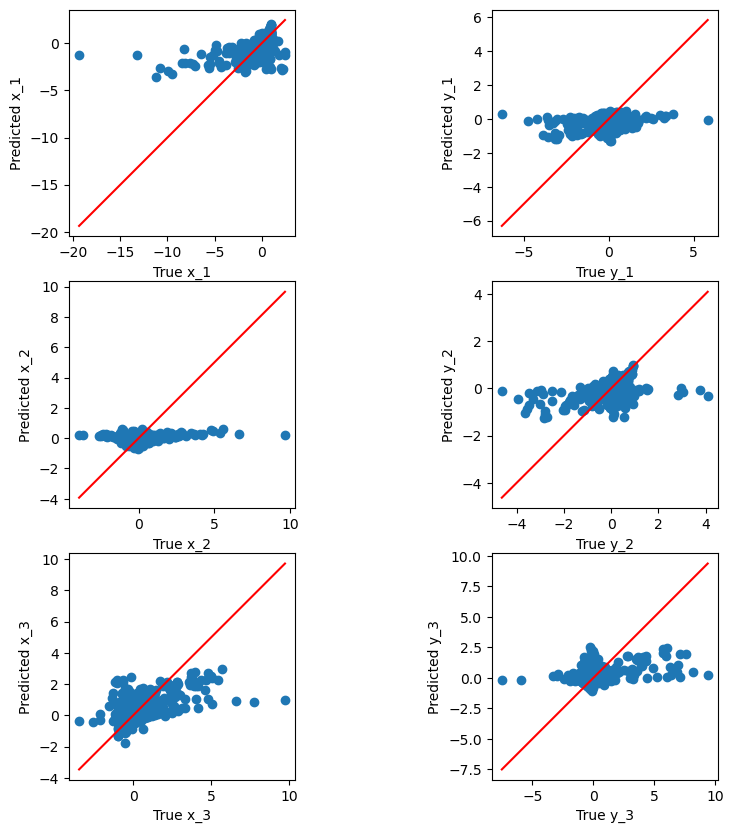

RMSE on test set: 1.3260


In [44]:
y_pred = best_model_L2.predict(X_test)
plot_y_yhat(y_test.values, y_pred, plot_title="Best Model Predictions")
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE on test set: {rmse_test:.4f}")

In [45]:
X_test = test[['t','x0_1','y0_1','x0_2','y0_2','x0_3','y0_3']].copy()
X_test.columns = ['t','x_1','y_1','x_2','y_2','x_3','y_3'] 


ids = test['Id']


predictions = best_model_L2.predict(X_test)

target_cols = ['x_1','y_1','x_2','y_2','x_3','y_3']
output_df = pd.DataFrame(predictions, columns=target_cols)
output_df.insert(0, 'Id', ids)


output_df.to_csv('polynomial_submission.csv', index=False)